### Reference Documentation

In [1]:
# https://python.langchain.com/docs/integrations/retrievers/merger_retriever/
# https://python.langchain.com/docs/modules/data_connection/retrievers/contextual_compression/

### Imports

In [5]:
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings # defaults to llama2

from langchain.retrievers.merger_retriever import MergerRetriever

DB_DIR = "./chroma_db_test"

### Langsmith setup to debug chain in detail

In [2]:
# Langsmith - to debug LLM responses

import os
from dotenv import load_dotenv
from langsmith import Client

load_dotenv()

lcs = os.getenv("LANGCHAIN_SECRET")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "llm-multi-doc-single-vdb"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = lcs

client = Client()

### Load all collections and create LOTR retriever

In [6]:
sys_docs = Chroma(
    collection_name="system-documentation",
    persist_directory=DB_DIR,
    embedding_function=OllamaEmbeddings(),
)

llm_papers = Chroma(
    collection_name="llm-papers",
    persist_directory=DB_DIR,
    embedding_function=OllamaEmbeddings(),
)

ssi_docs = Chroma(
    collection_name="ssi-docs",
    persist_directory=DB_DIR,
    embedding_function=OllamaEmbeddings(),
)

In [7]:
# Define 3 diff retrievers
sys_docs_ret = sys_docs.as_retriever(search_type="similarity", search_kwargs={"k": 2})
llm_papers_ret = llm_papers.as_retriever(
    search_type="similarity", search_kwargs={"k": 2}
)
ssi_docs_ret = ssi_docs.as_retriever(search_type="similarity", search_kwargs={"k": 2})

# We just pass a list of retrievers.
merge_retriever = MergerRetriever(
    retrievers=[sys_docs_ret, llm_papers_ret, ssi_docs_ret]
)

### Experiments with Document Filtering

In [8]:
# moving the import here, easier to chop and change
from langchain.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import DocumentCompressorPipeline,EmbeddingsFilter,LLMChainFilter,LLMChainExtractor
from langchain.retrievers import ContextualCompressionRetriever

For a simple question like below, baseline should be retriever getting first line from the doc.

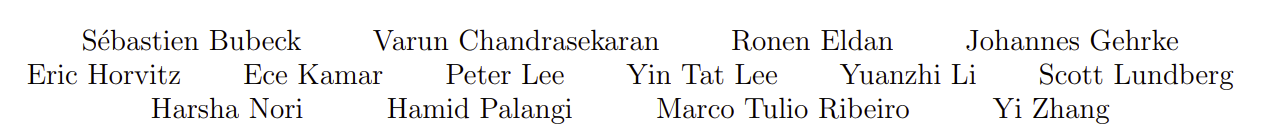

#### EmbeddingsFilter

In [6]:
relevant_filter = EmbeddingsFilter(embeddings=OllamaEmbeddings())
pipeline_comp = DocumentCompressorPipeline(transformers=[relevant_filter])

compression_retriever = ContextualCompressionRetriever(
    base_compressor=pipeline_comp, base_retriever=merge_retriever
)

compression_retriever.get_relevant_documents("Can you please give me authors of the paper titled Sparks of Artificial General Intelligence?")

# As seen below, basic filtering doesn't work. Returns all 6 docs as each retriever has k=2

[_DocumentWithState(page_content="Deep Learning. Writing code for deep learning requires knowledge of mathematics, statistics, and fa-\nmiliarity with frameworks and libraries such as PyTorch, TensorFlow, Keras, etc. In Figure 3.4 we ask both\nGPT-4 and ChatGPT to write a custom optimizer module, a task that can be challenging and error-prone\neven for human deep learning experts. We give these models a natural language description, which includes\na sequence of non-trivial operations such as applying SVD, truncating a matrix spectrally at the top-k and\ntop-2k eigenvalues, normalizing the top-k truncated matrix using the F-norm of the top-2k truncated matrix,\napplying momentum and weight decay. These instructions are not spelled out in complete detail, e.g., “ap-\nply momentum on Gk” requires “deep learning common sense”. It is important to note that this particular\noptimizer does not exist in the literature or on the internet, and thus the models cannot have it memorized,\nand must

#### LLMChainFilter

In [12]:
from langchain_community.llms import Ollama
llm = Ollama(model="mistral")

In [14]:
relevant_filter = LLMChainFilter.from_llm(llm)
pipeline_comp = DocumentCompressorPipeline(transformers=[relevant_filter])

compression_retriever = ContextualCompressionRetriever(
    base_compressor=pipeline_comp, base_retriever=merge_retriever
)

compression_retriever.get_relevant_documents("Who are the authors of Sparks of Artificial General Intelligence?")

# As seen below, llm chain has returned 5 instead of baseline 6 documents.

/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/

[Document(page_content='Sparks of Artiﬁcial General Intelligence:\nEarly experiments with GPT-4\nS´ ebastien Bubeck Varun Chandrasekaran Ronen Eldan Johannes Gehrke\nEric Horvitz Ece Kamar Peter Lee Yin Tat Lee Yuanzhi Li Scott Lundberg\nHarsha Nori Hamid Palangi Marco Tulio Ribeiro Yi Zhang\nMicrosoft Research\nAbstract\nArtiﬁcial intelligence (AI) researchers have been developing and reﬁning large language models (LLMs)\nthat exhibit remarkable capabilities across a variety of domains and tasks, challenging our understanding\nof learning and cognition. The latest model developed by OpenAI, GPT-4 [Ope23], was trained using an\nunprecedented scale of compute and data. In this paper, we report on our investigation of an early version\nof GPT-4, when it was still in active development by OpenAI. We contend that (this early version of) GPT-\n4 is part of a new cohort of LLMs (along with ChatGPT and Google’s PaLM for example) that exhibit\nmore general intelligence than previous AI models.

In [16]:
compression_retriever.get_relevant_documents("How do I check shape of data in pandas?")

/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/

[Document(page_content='In [293]: s\nOut[293]: \n0   1 days 00:00:05\n1   1 days 00:00:06\n2   1 days 00:00:07\n3   1 days 00:00:08\ndtype: timedelta64[ns]\n\nIn [294]: s.dt.days\nOut[294]: \n0    1\n1    1\n2    1\n3    1\ndtype: int64\n\nIn [295]: s.dt.seconds\nOut[295]: \n0    5\n1    6\n2    7\n3    8\ndtype: int32\n\nIn [296]: s.dt.components\nOut[296]: \n   days  hours  minutes  seconds  milliseconds  microseconds  nanoseconds\n0     1      0        0        5             0             0            0\n1     1      0        0        6             0             0            0\n2     1      0        0        7             0             0            0\n3     1      0        0        8             0             0            0\n\n\n\nNote\nSeries.dt will raise a TypeError if you access with a non-datetime-like values.', metadata={'source': 'data/system-documentation/pandas-basics.html', 'title': 'Essential basic functionality — pandas 2.2.2 documentation'})]

In [18]:
compression_retriever.get_relevant_documents("Please provide settlement instructions for BAHRAIN")

/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/

[Document(page_content='Deutsche Bank AG, Frankfurt Cash Equities    \n                           \n \n  \n3 | P a g e   \nJanuary 2021  \n For internal use only  COUNTRY                 SETTLEMENT INSTRUCTIONS                        SWIFT CODE   \n  \n  \nEUROCLEAR                   Euroclear. Brussels                                                           MGTCBEBEECL  \n                                          A/C 77838  \n                                          Place of settlement = MGTCBEBEXXX  \n    \n  \n  \nESTONIA                          SWEDBANK AS                                                                          HABAEE2 XXXX  \nA/c no: 99103794855                                                                               \nPlace of settlement =  ECSD EE2XXXX  \n  \n  \nFINLAND                         Nordea Bank AB (publ), Finnish Branch                         NDEAFIHHXXX  \n                                         Place of settlement = APKEFIHHXXX   \n  \n 

#### EmbeddingsFilter - With similarity thresholds

In [11]:
relevant_filter = EmbeddingsFilter(embeddings=OllamaEmbeddings(),similarity_threshold=0.8)
pipeline_comp = DocumentCompressorPipeline(transformers=[relevant_filter])

compression_retriever = ContextualCompressionRetriever(
    base_compressor=pipeline_comp, base_retriever=merge_retriever
)

compression_retriever.get_relevant_documents("Can you please give me authors of the paper titled Sparks of Artificial General Intelligence?")

# As seen below return no documents.

[]

#### EmbeddingsRedundantFilter

In [13]:
relevant_filter = EmbeddingsRedundantFilter(embeddings=OllamaEmbeddings(),similarity_threshold=0.95)
pipeline_comp = DocumentCompressorPipeline(transformers=[relevant_filter])

compression_retriever = ContextualCompressionRetriever(
    base_compressor=pipeline_comp, base_retriever=merge_retriever
)

compression_retriever.get_relevant_documents("Can you please give me authors of the paper titled Sparks of Artificial General Intelligence?")

# As seen below return no documents.

[_DocumentWithState(page_content='In [293]: s\nOut[293]: \n0   1 days 00:00:05\n1   1 days 00:00:06\n2   1 days 00:00:07\n3   1 days 00:00:08\ndtype: timedelta64[ns]\n\nIn [294]: s.dt.days\nOut[294]: \n0    1\n1    1\n2    1\n3    1\ndtype: int64\n\nIn [295]: s.dt.seconds\nOut[295]: \n0    5\n1    6\n2    7\n3    8\ndtype: int32\n\nIn [296]: s.dt.components\nOut[296]: \n   days  hours  minutes  seconds  milliseconds  microseconds  nanoseconds\n0     1      0        0        5             0             0            0\n1     1      0        0        6             0             0            0\n2     1      0        0        7             0             0            0\n3     1      0        0        8             0             0            0\n\n\n\nNote\nSeries.dt will raise a TypeError if you access with a non-datetime-like values.', metadata={'source': 'data/system-documentation/pandas-basics.html', 'title': 'Essential basic functionality — pandas 2.2.2 documentation'}, state={'embedded_d

#### LLMChainExtractor without DocumentCompressorPipeline

In [9]:
from langchain_community.llms import Ollama
llm = Ollama(model="mistral")

In [11]:
relevant_filter = LLMChainExtractor.from_llm(llm)
pipeline_comp = DocumentCompressorPipeline(transformers=[relevant_filter])

compression_retriever = ContextualCompressionRetriever(
    base_compressor=pipeline_comp, base_retriever=merge_retriever
)

compression_retriever.get_relevant_documents("Can you please give me authors of the paper titled Sparks of Artificial General Intelligence?")

/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/

[Document(page_content='NO_OUTPUT. The context does not provide any information about the paper titled "Sparks of Artificial General Intelligence" and its authors.', metadata={'source': 'data/system-documentation/pandas-basics.html', 'title': 'Essential basic functionality — pandas 2.2.2 documentation'}),
 Document(page_content='The context does not provide any information about the authors of the paper titled "Sparks of Artificial General Intelligence". Therefore, no output is relevant to answer the question.\n\nRelevant parts of the context (none in this case):\n---\n\n(Note: There is no relevant part of the context extracted as the question asks for authors of a different paper.)', metadata={'page': 24, 'source': 'data/llm-papers/openai-paper.pdf'}),
 Document(page_content='NO_OUTPUT. The context does not contain any information about the authors of the paper titled "Sparks of Artificial General Intelligence".', metadata={'page': 8, 'source': 'data/ssi-docs/db-ssi.pdf'}),
 Document(

#### LLMChainFilter without DocumentCompressorPipeline

In [27]:
relevant_filter = LLMChainFilter.from_llm(llm)

compression_retriever = ContextualCompressionRetriever(
    base_compressor=relevant_filter, base_retriever=merge_retriever
)

compression_retriever.get_relevant_documents("Who are authors of the paper titled Sparks of Artificial General Intelligence?")


/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/

[Document(page_content='In [293]: s\nOut[293]: \n0   1 days 00:00:05\n1   1 days 00:00:06\n2   1 days 00:00:07\n3   1 days 00:00:08\ndtype: timedelta64[ns]\n\nIn [294]: s.dt.days\nOut[294]: \n0    1\n1    1\n2    1\n3    1\ndtype: int64\n\nIn [295]: s.dt.seconds\nOut[295]: \n0    5\n1    6\n2    7\n3    8\ndtype: int32\n\nIn [296]: s.dt.components\nOut[296]: \n   days  hours  minutes  seconds  milliseconds  microseconds  nanoseconds\n0     1      0        0        5             0             0            0\n1     1      0        0        6             0             0            0\n2     1      0        0        7             0             0            0\n3     1      0        0        8             0             0            0\n\n\n\nNote\nSeries.dt will raise a TypeError if you access with a non-datetime-like values.', metadata={'source': 'data/system-documentation/pandas-basics.html', 'title': 'Essential basic functionality — pandas 2.2.2 documentation'}),
 Document(page_content='Spa

#### LLM Based filters

LLM based filters have better tracing on Langsmith. For given documents, we can see which documents did LLM marked as relevant YES vs no NO

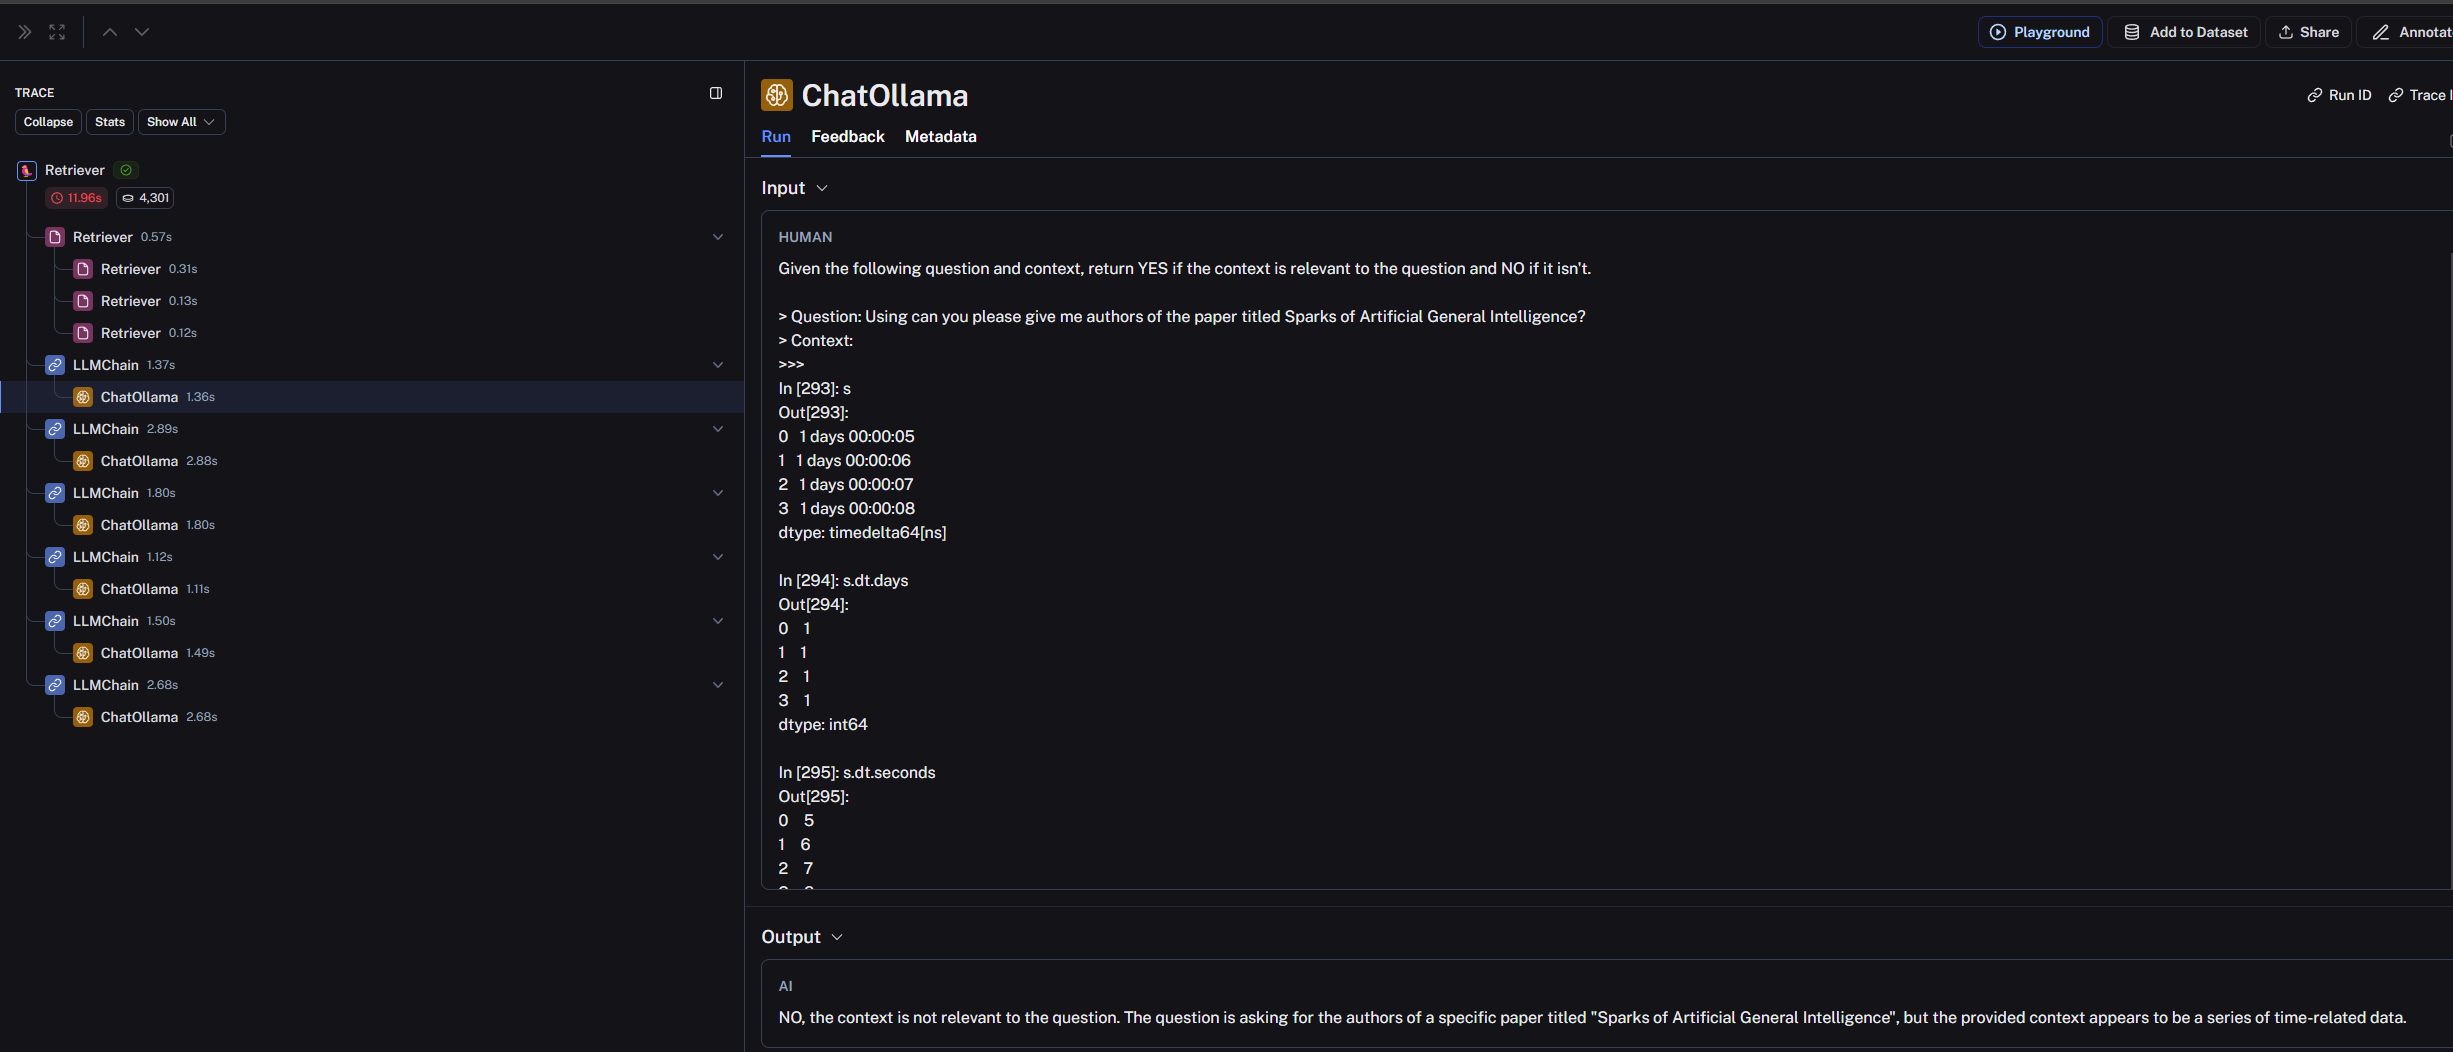

### LLM QA Chain 

In [27]:
from langchain_community.chat_models import ChatOllama
from langchain.chains import RetrievalQA

llm = ChatOllama(model="mistral")

The final chain doesn't need much work. All heavy lifting should be done in retriever space to pass correct document to LLM.

In [28]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=compression_retriever,
    return_source_documents=True,
)

In [29]:
# response parser
def process_llm_response(llm_response):
    print(llm_response["result"])
    print("\nSources:")
    sources = set([x.metadata["source"] for x in llm_response["source_documents"]])
    print(sources)

In [30]:
process_llm_response(
    qa_chain.invoke(
        "Who are the authors of Sparks of Artificial General Intelligence?"
    )
)

/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/

 The authors of "Sparks of Artificial General Intelligence" are: Sebastien Bubeck, Varun Chandrasekaran, Ronen Eldan, Eric Horvitz, Ece Kamar, Peter Lee, Yin Tat Lee, Yuanzhi Li, Harsha Nori, Hamid Palangi, Marco Tulio Ribeiro, and Yi Zhang.

Sources:
{'data/llm-papers/openai-paper.pdf'}


In [32]:
process_llm_response(
    qa_chain.invoke(
        "How do I check shape of data in pandas?"
    )
)

/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/

 To check the shape (number of rows and columns) of a Pandas Series, you can use the `shape` attribute or the `size` attribute. Here's how to use them:

```python
In [297]: s.shape  # number of rows and number of columns as a tuple (row, column)
Out[297]: (len(s),)

In [298]: s.size        # total number of elements in the Series
Out[298]: len(s)
```

However, since you provided a datetime Series, let me clarify that: The code snippets given earlier were showing how to extract various components from each element (i.e., timedelta64 values) of the Series named `s`. In this case, there are no missing data as all elements have equal shape (one-dimensional with a single row). Therefore, the shape and size will be 1 for the entire Series or equivalently, the number of elements in it.

To summarize:

1. To check the shape or size of a Series, use `shape` or `size`.
2. In this specific example, since the Series contains equal-shaped datetime values, both shape and size will be 1.

Sources:
{'

In [33]:
process_llm_response(
    qa_chain.invoke("Please provide settlement instruction details for BAHRAIN")
)

/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/rbhat-win/miniconda3/envs/test-lab-310/lib/python3.10/site-packages/langchain/

 The settlement instructions for Bahrain are as follows:

Country: Bahrain
Settlement Instructions:

BANK: HSBC Bank Middle East, Qatar
Account number (A/C): Deutsche Bank AG London A/C 001-044387-088 (stock)
Place of settlement: DSMDQAQAXXX
Use Beneficiary BIC: DEUTGB22EEQ (for HSBC Middle East, Bahrain BBMEQAQXXXX)

Alternatively, for clearing through an agent, use the following details:
Bank: Saudi British Bank (Riyadh)
Account number (A/C): 086-003969-123 (Stock)
Place of settlement: TSSMSAR1XXX
Use Beneficiary BIC: DEUTGB22EEQ

Sources:
{'data/ssi-docs/db-ssi.pdf'}
